In [2]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

az.style.use("arviz-darkgrid")

# Learning to use PyMC

### Synthetic Data - Linear Regression 

Simple Bayesian linear regression model with normal priors for the parameters. Want to predict outcomes Y as noramlly-distributed observations with expected value $\mu$ - a linear function of two predictors $X_1$ and $X_2$

$Y \sim N(\mu, \sigma^2 )$

$\mu = \alpha + \beta_1 X_1 + \beta_2 X_2 $

$\sigma$ represents the observation errror!

To construct Baysesian model need to assign a prior distribution to the unknowns in the model. Choose zero-mean normal priors with a variance of 100 for the regression coefficents - weak information regarding the parameter values. Choose a half-normal distribution (bound at zero) as prior for $\sigma$

$\alpha \sim N(0,100)$

$\beta_i \sim N(0,100)$

$\sigma \sim |N(0,1)|$

In [2]:
# simulate artifical data with NumPy's random module

# true parameter values
alpha, sigma = 1, 1
betas = [1, 2.5]

size = 100

# Predictor variables
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# simulated outcome
Y = alpha + betas[0]*X1 + betas[1]*X2 + np.random.randn(size)*sigma



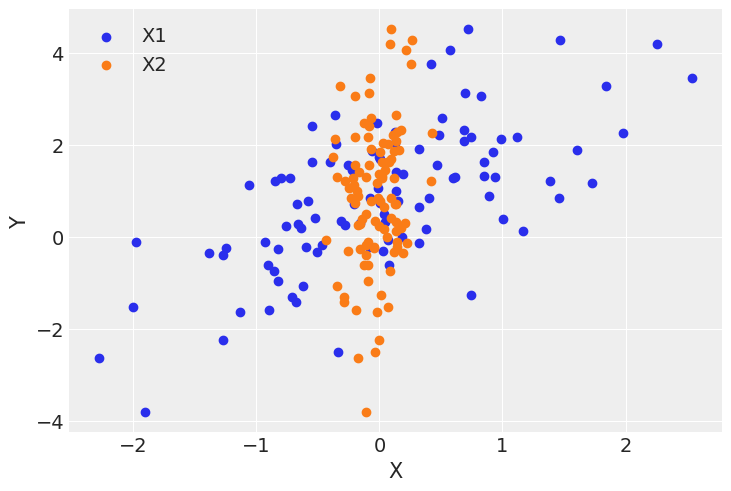

In [3]:
plt.scatter(X1, Y, label='X1')
plt.scatter(X2, Y, label='X2')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### PyMC Building the Model

In [5]:
basic_model = pm.Model()

with basic_model:
    
    # priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2
    
    # Likelikhood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [ ]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

In [ ]:
idata

In [37]:
idata.posterior['alpha'].sel(draw=slice(0,4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[0.90284307, 0.90997958, 0.90997958, 0.90997958, 0.87691152],
       [0.92567032, 0.8594506 , 0.8572977 , 0.90315578, 0.9166049 ],
       [1.03366903, 0.82360858, 0.98244879, 1.02365916, 0.88261605],
       [0.83232855, 0.8900687 , 0.90798942, 0.95207477, 0.95551283]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

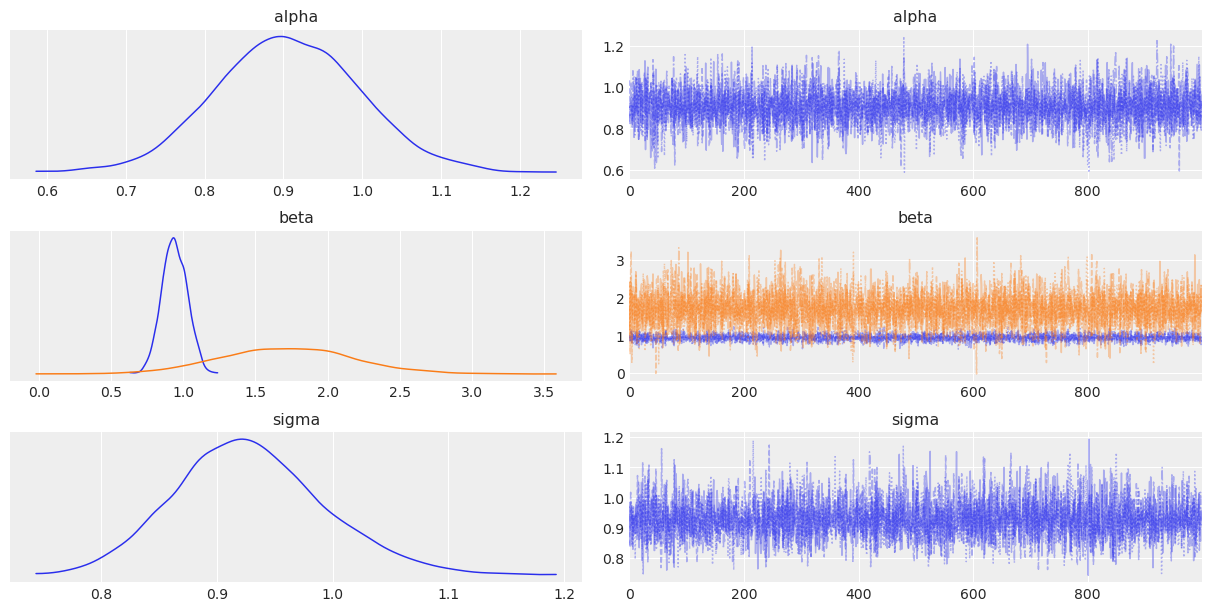

In [39]:
az.plot_trace(idata, combined=True)

In [40]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.91,0.09,0.74,1.08,0.00,0.0,6763.13,3492.75,1.0
beta[0],0.94,0.09,0.79,1.11,0.00,0.0,6382.04,3236.00,1.0
beta[1],1.71,0.46,0.90,2.63,0.01,0.0,5941.17,3304.85,1.0
sigma,0.93,0.07,0.81,1.06,0.00,0.0,5690.67,3189.97,1.0


--------------------------
### Educational Outcomes for Hearing-impaired Children
#### Multivariate Regression

Determine factors associated with better/decreased learning outcomes

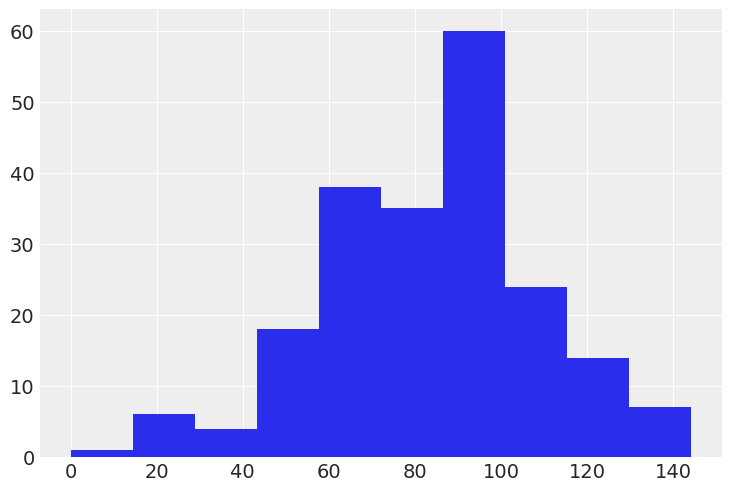

In [3]:
import pandas as pd
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)

test_scores['score'].hist();

test_scores = test_scores.drop(columns=['mother_hs'])
X = test_scores.dropna().astype(float).reset_index(drop=True)
y = X.pop('score')

# renormalise
X -= X.mean()
X /= X.std()

N,D = X.shape

Regularisation: ineffective covariates shrunk towards zero by applying some  penalty to the regression parameters if they don't contribute to prediction outcomes - a form of variable selection

In Bayesian context: apply appropriate prior distribution to regression coefficents. One prior is the Hierarchical regularised horseshoe, with two regularisation strategies: a `global set of parmaters` and `local set of parameters` for each coefficent.

Long-tailed distributions as shrinkage priors allow some to be non-zero while pushing the rest towards zero!

Horseshoe prior for each regression coefficent $\beta_i$:

$\beta \sim N(0, \tau^2 \bar \lambda^{2}_i)$

$\tau$ is the global shrinkage parameter and $ \bar \lambda_i$ is the local.

Prior for $\tau$ will use a Half-StudentT distribution - good choice due to its heavy-tailed nature 

$\tau \sim \text{Half-StudentT} \left( \dfrac{D_0}{D-D_0}  \dfrac{\sigma}{\sqrt{N}} \right)$

$D_0$ represents the true number of non-zero coefficents, only need a reasonable guess - within an order of magnitude of true value 

In [4]:
# Assume half the predictors as prior tau
D0 = D/2

Local shrinkeage parameters defined by:

$\bar \lambda^{2}_i = \dfrac{c^2 \lambda^{2}_i}{c^2 + \tau^2 \lambda^{2}_i} $

Need priors on $ \lambda_i $ and c - again will use a long-tailed Half-StudentT(1). $c^2$ needs to be strictly positive but not long-tailed - use an inverse gamma

$ \lambda_i \sim \text{Half-StudentT}(1) $

$ c^2 \sim \text{InverseGamma}(1,1) $

To increase efficency of NUTS sampler, $\beta$ is re-parameterised:

$z_i = N(0,1)$

$\beta_i = z_i \cdot \tau \cdot \bar \lambda_i $

In [5]:
import aesara.tensor as at

# passing input variable names into model as coordinates called predictors
# can replace the shape int argument with vector of names 
# This associates an appropriate name with each latent parameter

with pm.Model(coords={"predictors":X.columns.values}) as test_score_model:
    
    # prior on error standard deviation
    sigma = pm.HalfNormal("sigma", 25)
    
    # global shrinkage prior
    tau = pm.HalfStudentT( "tau", 2, ( D0/(D-D0) ) * (sigma/np.sqrt(N)) )
    
    # local shrinkage priors
    lam = pm.HalfStudentT("lam", 2, dims="predictors")
    c2  = pm.InverseGamma("c2", 1, 0.1)
    z = pm.Normal("z", 0, 1, dims="predictors")
    
    # Shrunken coefficients
    beta = pm.Deterministic("beta", z * tau * lam * at.sqrt( c2/(c2 + tau**2 * lam**2) ),
                           dims = "predictors")
    
    # no shrinkage on the intercept!
    beta0 = pm.Normal("beta0", 100, 25.0)
    
    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

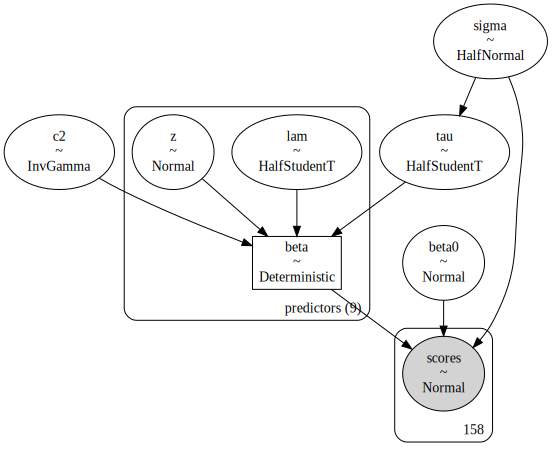

In [6]:
pm.model_to_graphviz(test_score_model)

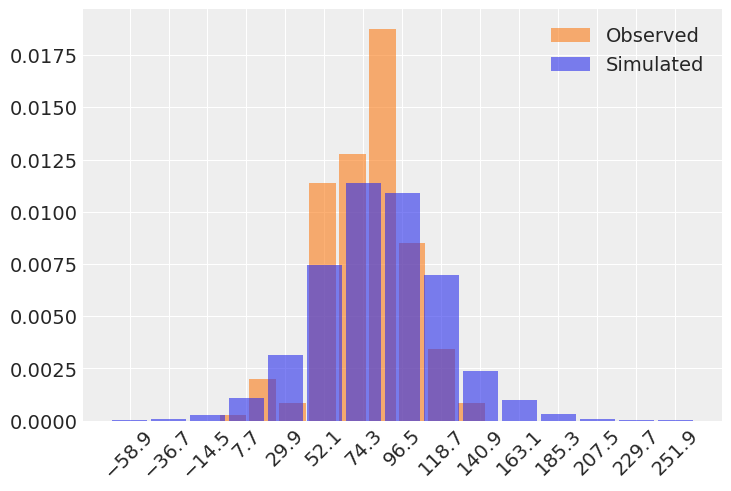

In [10]:
# what does the model do before it sees any data?
# prior predictive sampling

with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)
    
az.plot_dist(test_scores['score'].values, kind='hist', color='C1',
             hist_kwargs=dict(alpha=0.6), label='Observed')

az.plot_dist(prior_samples.prior_predictive['scores'], kind='hist',
             hist_kwargs=dict(alpha=0.6), label='Simulated')

plt.xticks(rotation=45);

In [12]:
# Model fiutting with PyMC sample

with test_score_model:

    idata = pm.sample(1000, tune=4000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 87 seconds.


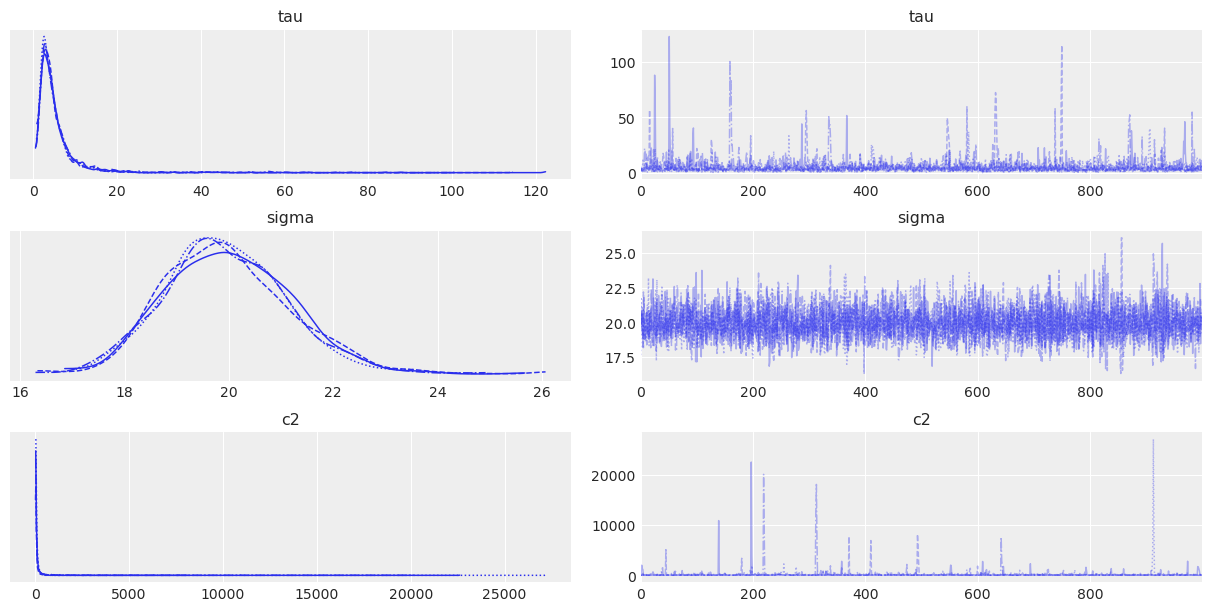

In [13]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

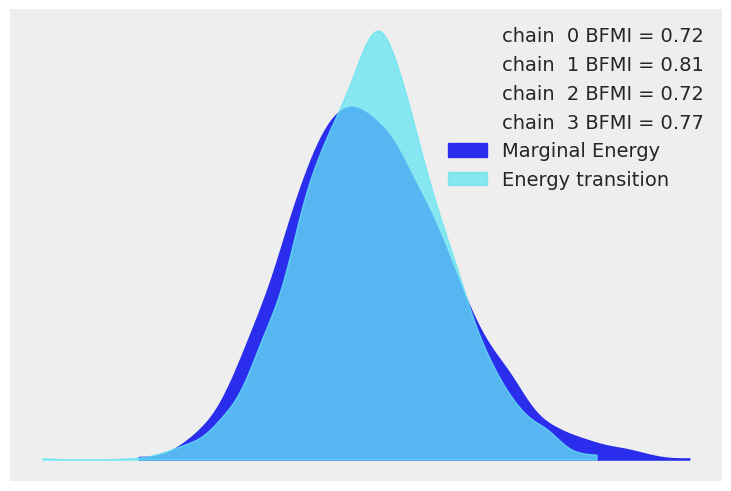

In [15]:
az.plot_energy(idata);

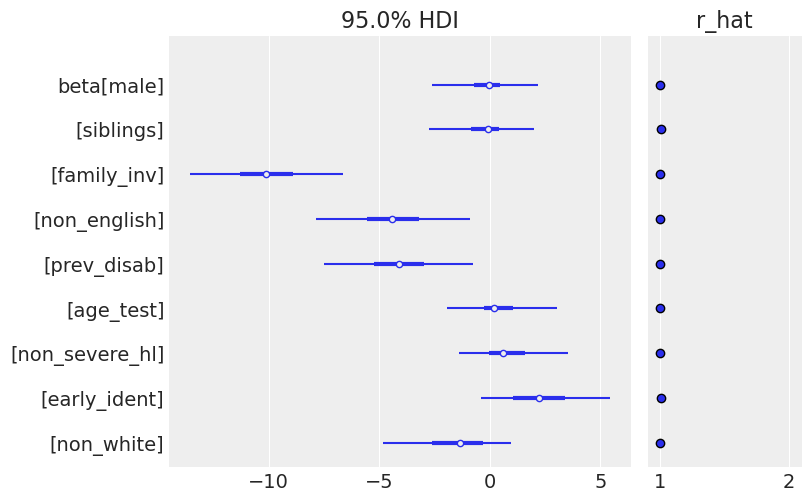

In [16]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [47]:
with pm.Model() as model:
    lamda = pm.Poisson("lamda", 3)
    prior_sample = pm.sample_prior_predictive(1000)

Text(0.5, 1.0, 'Prior distribution for Poisson')

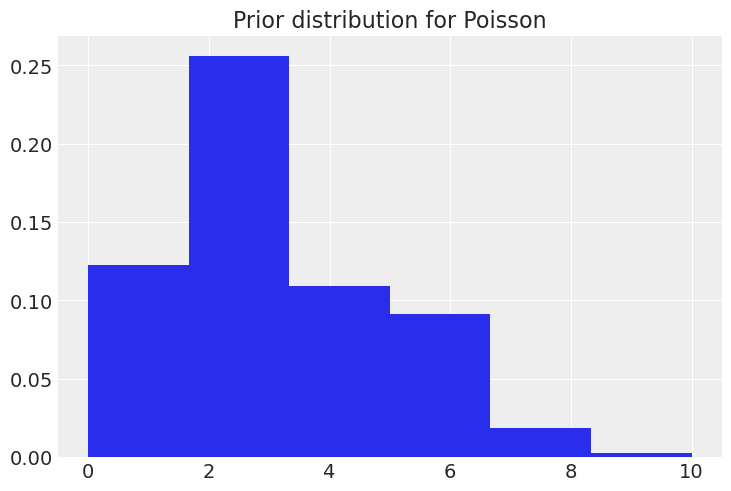

In [48]:
plt.hist(list(prior_sample.prior['lamda'].values), bins=6, density=True, histtype="stepfilled")
plt.title("Prior distribution for Poisson")



In [34]:
prior_sample

Inference data with groups:
	> prior

## Modeling Approaches

In [54]:
# tau is the switch point when user's behaviour changes 
# change in model parameter

tau = np.random.randint(0,80)
print('tau = ', tau)

alpha = 1/20
lamda_1, lamda_2 = np.random.exponential(scale=1/alpha, size=2)
print('lamda_1 = ', lamda_1, ' & lamda_2 = ', lamda_2)

tau =  38
lamda_1 =  52.62823041787314  & lamda_2 =  12.831975894168629


In [56]:
import scipy.stats as stats

data = np.r_[stats.poisson.rvs(mu=lamda_1, size=tau), stats.poisson.rvs(mu=lamda_2, size = 80 - tau)]

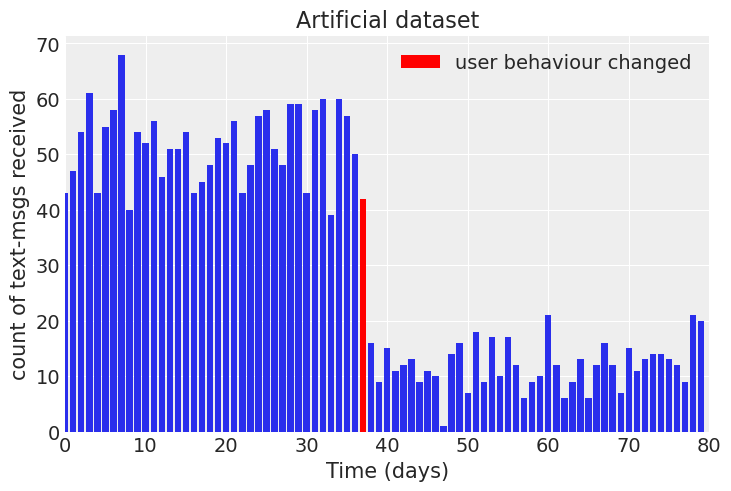

In [60]:
plt.bar(np.arange(80), data)
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

### Bayesian A/B Testing

## Cheating amongst students!

We can't expect any student (even with a get out of jail free card) to openly admit to cheating in an exam. Short of resorting to the thumb screws, we need to give students a way to be honest while preserving their privacy.

__Confession algorithm:__

Student filps a coin and hides the result from the interviewer.

**Students can lie about the outcome of each coin flip**

> heads: student agrees to answer honestly

> tails: flip the coin again:

>  > heads: Yes, I did cheat

>  > tails: No, I didn't cheat

The interviewer can't know if any individual's `yes` is `guilty plea` or the result of a `heads on the second toss`!

100 students interviewed for cheating

Want to find p (proportion of cheaters!)

 $ p = \dfrac{N_{cheaters}}{N_{Total}} $

In [29]:
# Sample p from a prior
# Ignorant about p - prior = Uniform(0,1)

import pymc as pm

N = 100

basic_model = pm.Model()

with basic_model:
    p = pm.Uniform("freq_cheating", 0, 1)
    true_answers = pm.Bernoulli("truths", p, size=N)
    
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, size=N)
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, size=N)




SyntaxError: 'yield' outside function (<ipython-input-29-1cf54f4386c9>, line 12)

In [28]:
first_coin_flips * second_coin_flips

Elemwise{mul,no_inplace}.0

In [12]:


with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1)
    data_generator = pm.Poisson("data_generator", parameter)

with model:
    data_plus_one = data_generator + 1

In [10]:
parameter.tag.test_value

AttributeError: 'ValidatingScratchpad' object has no attribute 'test_value'